In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import peakutils
import json

In [2]:
DB_NAME = '/home/ubuntu/UPS2_allion/UPS2_allion-features-1-1097.sqlite'
CONV_DB_NAME = '/home/ubuntu/UPS2_allion/UPS2_allion.sqlite'
FEATURE_ID = 23
BASE_PEAK_ID = 2
MAX_RT_DISTANCE = 2
MAX_SCAN_DISTANCE = 5
MAX_NUMBER_OF_PEAKS = 20

In [3]:
db_conn = sqlite3.connect(DB_NAME)
src_c = db_conn.cursor()
src_c.execute("CREATE INDEX IF NOT EXISTS idx_summed_ms2_regions_1 ON summed_ms2_regions (feature_id, peak_id)")
db_conn.close()

In [4]:
db_conn = sqlite3.connect(DB_NAME)
src_c = db_conn.cursor()
src_c.execute("CREATE INDEX IF NOT EXISTS idx_ms2_peaks_2 ON ms2_peaks (feature_id, peak_id)")
db_conn.close()

In [5]:
# Load the peak points for the best CofM-matching peaks for this feature
db_conn = sqlite3.connect(DB_NAME)
ms2_peak_points_df = pd.read_sql_query("select peak_id,mz,scan,intensity from summed_ms2_regions where feature_id || '-' || peak_id in (select feature_id || '-' || ms2_peak_id from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {})".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, MAX_NUMBER_OF_PEAKS), db_conn)
db_conn.close()

In [6]:
# load the feature's base peak points
db_conn = sqlite3.connect(DB_NAME)
base_peak_points_df = pd.read_sql_query("select point_id,mz,scan,intensity from summed_ms1_regions where feature_id={} and peak_id={}".format(FEATURE_ID, BASE_PEAK_ID), db_conn)
db_conn.close()

In [7]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

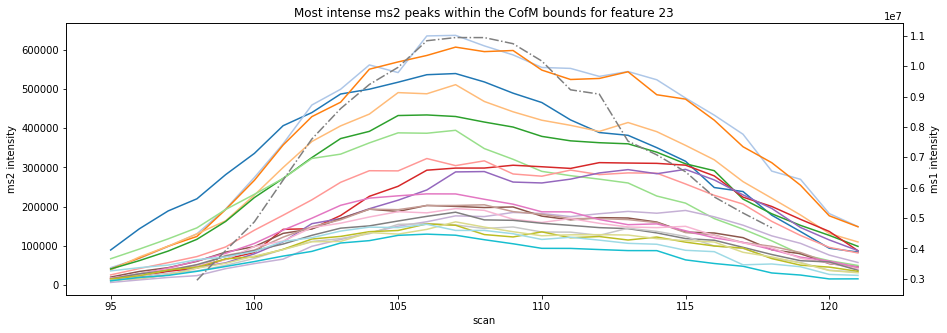

In [8]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
groups = ms2_peak_points_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax1.plot(group.scan, group.intensity, color=tableau20[i%len(tableau20)], label=name)
ax2.plot(base_peak_points_df.scan, base_peak_points_df.intensity, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax1.set_ylabel('ms2 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms1 intensity')
plt.title('Most intense ms2 peaks within the CofM bounds for feature {}'.format(FEATURE_ID))
plt.margins(0.06)
plt.show()

In [23]:
NUMBER_OF_PEAKS = 500

In [24]:
# find the most intense ms2 peaks for this feature that match in centre-of-mass
db_conn = sqlite3.connect(DB_NAME)
peak_correlation_df = pd.read_sql_query("select * from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {}".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, NUMBER_OF_PEAKS), db_conn)
db_conn.close()

In [25]:
# get the ms2 peaks for the feature
db_conn = sqlite3.connect(DB_NAME)
ms2_peaks_df = pd.read_sql_query("select feature_id,peak_id,centroid_mz from ms2_peaks where feature_id || '-' || peak_id in (select feature_id || '-' || ms2_peak_id from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {})".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, NUMBER_OF_PEAKS), db_conn)
db_conn.close()

In [26]:
ms2_peaks_df.head()

,feature_id,peak_id,centroid_mz
0,23,1,588.361
1,23,2,861.007
2,23,3,861.508
3,23,4,775.952
4,23,5,776.454


In [27]:
peak_correlation_df.head()

,feature_id,base_peak_id,ms1_scan_centroid,ms1_rt_centroid,ms2_peak_id,ms2_scan_centroid,ms2_rt_centroid,scan_distance,rt_distance,correlation
0,23,2,110.144302,1151.36315,1,107.403725,1151.336424,2.740577,0.026726,0.0
1,23,2,110.144302,1151.36315,2,108.975504,1151.332457,1.168798,0.030693,0.0
2,23,2,110.144302,1151.36315,3,108.986546,1151.332787,1.157756,0.030363,0.0
3,23,2,110.144302,1151.36315,4,108.607330,1151.335597,1.536972,0.027553,0.0
4,23,2,110.144302,1151.36315,5,108.514538,1151.333596,1.629764,0.029554,0.0


In [28]:
merged_ms2_peak_df = pd.merge(ms2_peaks_df, peak_correlation_df, left_on=['feature_id','peak_id'], right_on=['feature_id','ms2_peak_id'])

In [39]:
len(merged_ms2_peak_df)

500

In [29]:
merged_ms2_peak_df.head()

,feature_id,peak_id,centroid_mz,base_peak_id,ms1_scan_centroid,ms1_rt_centroid,ms2_peak_id,ms2_scan_centroid,ms2_rt_centroid,scan_distance,rt_distance,correlation
0,23,1,588.361,2,110.144302,1151.36315,1,107.403725,1151.336424,2.740577,0.026726,0.0
1,23,2,861.007,2,110.144302,1151.36315,2,108.975504,1151.332457,1.168798,0.030693,0.0
2,23,3,861.508,2,110.144302,1151.36315,3,108.986546,1151.332787,1.157756,0.030363,0.0
3,23,4,775.952,2,110.144302,1151.36315,4,108.607330,1151.335597,1.536972,0.027553,0.0
4,23,5,776.454,2,110.144302,1151.36315,5,108.514538,1151.333596,1.629764,0.029554,0.0


In [30]:
z = np.polyfit(x=merged_ms2_peak_df.centroid_mz, y=merged_ms2_peak_df.scan_distance, deg=1)
p = np.poly1d(z)
merged_ms2_peak_df['trendline_scan'] = p(merged_ms2_peak_df.centroid_mz)

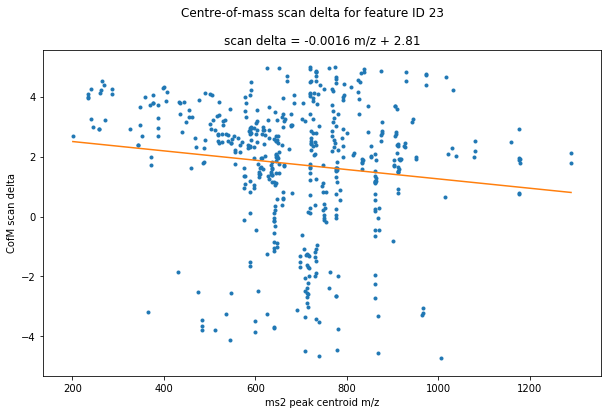

In [31]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.centroid_mz, merged_ms2_peak_df.scan_distance, marker='o', linestyle='', ms=3)
merged_ms2_peak_df.set_index(merged_ms2_peak_df.centroid_mz, inplace=True)
merged_ms2_peak_df.trendline_scan.sort_index(ascending=False).plot(ax=ax1)
plt.xlabel('ms2 peak centroid m/z')
plt.ylabel('CofM scan delta')
plt.margins(0.06)
plt.suptitle('Centre-of-mass scan delta for feature ID {}'.format(FEATURE_ID))
plt.title('scan delta = {0:.4f} m/z + {1:.2f}'.format(z[0],z[1]))
plt.show()

In [32]:
z = np.polyfit(x=merged_ms2_peak_df.centroid_mz, y=merged_ms2_peak_df.rt_distance, deg=1)
p = np.poly1d(z)
merged_ms2_peak_df['trendline_rt'] = p(merged_ms2_peak_df.centroid_mz)

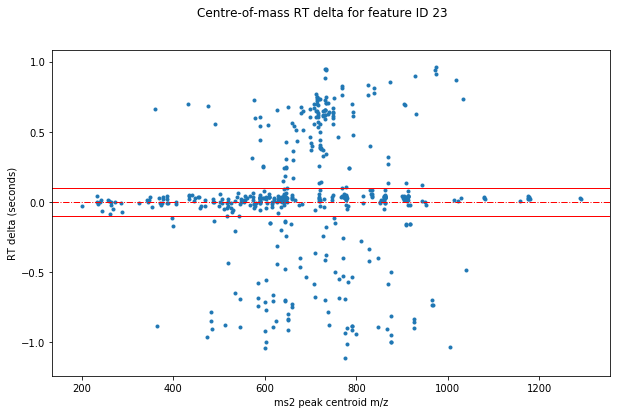

In [33]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.centroid_mz, merged_ms2_peak_df.rt_distance, marker='o', linestyle='', ms=3)
plt.axhline(y=0.1, color='r', linestyle='-', linewidth=1)
plt.axhline(y=0.0, color='r', linestyle='-.', linewidth=1)
plt.axhline(y=-0.1, color='r', linestyle='-', linewidth=1)
plt.xlabel('ms2 peak centroid m/z')
plt.ylabel('RT delta (seconds)')
plt.margins(0.06)
plt.suptitle('Centre-of-mass RT delta for feature ID {}'.format(FEATURE_ID))
plt.show()

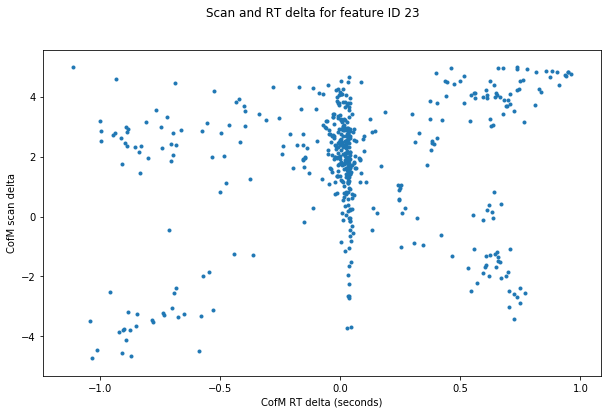

In [34]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.rt_distance, merged_ms2_peak_df.scan_distance, marker='o', linestyle='', ms=3)
plt.xlabel('CofM RT delta (seconds)')
plt.ylabel('CofM scan delta')
plt.margins(0.06)
plt.suptitle('Scan and RT delta for feature ID {}'.format(FEATURE_ID))
plt.show()

In [35]:
constrained_rt_df = merged_ms2_peak_df[abs(merged_ms2_peak_df.rt_distance) <= 0.1].copy()

In [38]:
len(constrained_rt_df)

266

In [36]:
z = np.polyfit(x=constrained_rt_df.centroid_mz, y=constrained_rt_df.scan_distance, deg=1)
p = np.poly1d(z)
constrained_rt_df['trendline_scan'] = p(constrained_rt_df.centroid_mz)

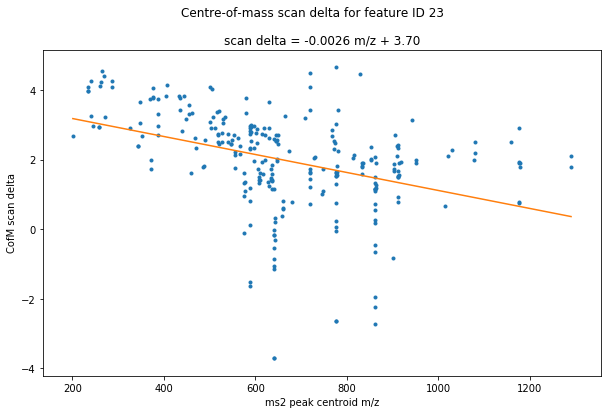

In [37]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(constrained_rt_df.centroid_mz, constrained_rt_df.scan_distance, marker='o', linestyle='', ms=3)
constrained_rt_df.set_index(constrained_rt_df.centroid_mz, inplace=True)
constrained_rt_df.trendline_scan.sort_index(ascending=False).plot(ax=ax1)
plt.xlabel('ms2 peak centroid m/z')
plt.ylabel('CofM scan delta')
plt.margins(0.06)
plt.suptitle('Centre-of-mass scan delta for feature ID {}'.format(FEATURE_ID))
plt.title('scan delta = {0:.4f} m/z + {1:.2f}'.format(z[0],z[1]))
plt.show()

Though there is a trend in drift delta, we can't be sure which peaks belong. So now we need to compare the features identified in DDA and DIA, to make sure which peaks are real.